In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Set the matplotlib output to svg
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

import os
# check for set environment variable JB_NOSHOW
show = True
if 'JB_NOSHOW' in os.environ:
    show = False

# Computational Fluid Dynamics

## Overview

The very general approach to numericaly solve a set of coupled PDEs is outlined in {numref}`fig-cfd-overview`. In case of fluid dynamics, these are the eqauations introduced earlier and numerical solution of those is called computational fluid dynmics (CFD).

:::{figure-md} fig-cfd-overview

<img src="./figs/numerical_solution_overview.svg" width="100%">

Overview of the general approach in computational fluid dynamics.
:::

The main aspect in solving PDEs is to approximate the involved derivatives. This approximation is carried out in a discretised domain and leads to a set of algebraic equations, eventually a system of linear equations. There exist multiple approximation approaches with different specialisations and properties, where these three are the most prominent ones:

* [Finite element method (FEM)](https://en.wikipedia.org/wiki/Finite_element_method)
* [Finite volume method (FVM)](https://en.wikipedia.org/wiki/Finite_volume_method)
* [Finite difference method (FDM)](https://en.wikipedia.org/wiki/Finite_difference_method)

As FDS is a FDM based solver, the main focus of this section is on the finite difference method. Yet, there will be also a few selected FVM aspects outlined.  

## Approximation of Derivatives

### Taylor Series

The [Taylor series](https://en.wikipedia.org/wiki/Taylor_series) can approximate any $\mf C^\infty$ function at an expansion point $\mf x_0$. The appoximation is given in terms of $\mf h$, being the coordinate variable in the vicinity of $\mf x_0$.

$$
\begin{align}
\mf f(x_0 + h) &=\mf \sum_{i=0}^{\infty}\frac{1}{i!}\left.\frac{d^if}{dx^i}\right|_{x_0}\cdot h^i \\ 
\mf &=\mf f(x_0) + f'(x_0)\cdot h + \frac{1}{2} f''(x_0)\cdot h^2 + \frac{1}{6}f'''(x_0)\cdot h^3 + \cdots
\end{align}
$$ (eq-taylor-series)

```{margin} Big O notation
The [big O notation](https://en.wikipedia.org/wiki/Big_O_notation) $\mf \mathcal{O}$ indicates the asymptotical behaviour of a function. In the approximation of derivatives, shown in this section, it indicates the functional reduction of the approximation error for $\mf h \rightarrow 0$.
```

In practice, the expansion is aborted at a given order $\mf \mathcal{O}(h^n)$, where $\mf n$ indicates the numer of Taylor terms considered, i.e. 

$$
\mf f(x_0 + h) =\sum_{i=0}^{n-1}\left(\frac{1}{i!}\left.\frac{d^if}{dx^i}\right|_{x_0}\cdot h^i\right) +  \mathcal{O}(h^n)\quad .
$$ (eq-taylor-series-n)

The expansion up to order three $\mf \mathcal{O}(h^3)$ takes following form

$$
\mf f(x_0 + h) = f(x_0) + f'(x_0)\cdot h + \frac{1}{2} f''(x_0)\cdot h^2 + \mathcal{O}(h^3)\quad .
$$ (eq-taylor-3rd)

**Example of a Taylor expansion**

As an example, the approximation of the function

$$
\mf f(x) = \frac{x}{10} + \frac{1}{1+x^2}
$$ (eq-cfd-example-fnk)

at the evaluation point $\mf x_0 = 2.0$.

In [2]:
# definition of the example function and its analytical derivatives
def fnk(x, derivative=0):
    if derivative == 1:
        return 0.1 - 2*x * (1+x**2)**(-2)
    if derivative == 2:
        return -2 * (1+x**2)**(-2) + 8*x**2 * (1+x**2)**(-3)
    if derivative == 3:
        return 8*x * (1+x**2)**(-3) + 16*x * (1+x**2)**(-3) - 48*x**3 * (1+x**2)**(-4)
    if derivative > 3:
        return None
    return 0.1*x + (1+x**2)**(-1)

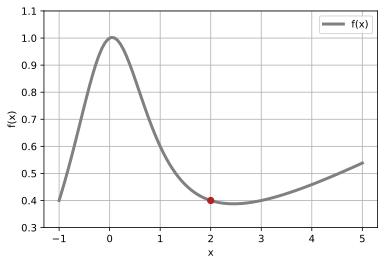

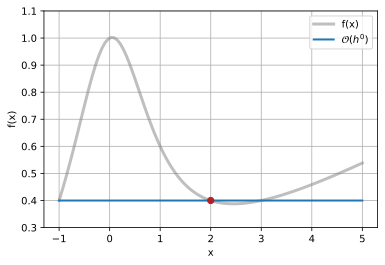

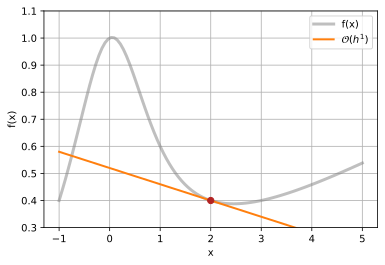

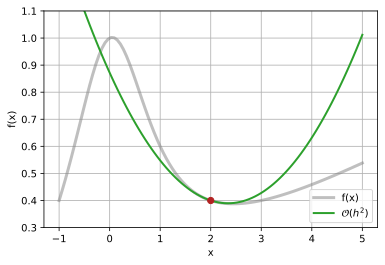

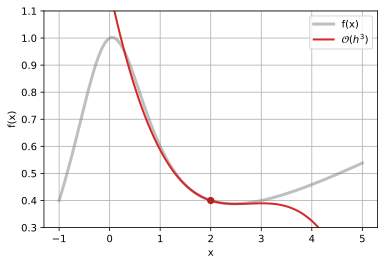

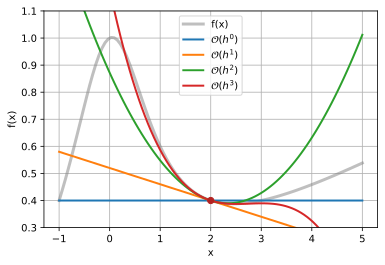

<Figure size 432x288 with 0 Axes>

In [10]:
# set interval for x
xb = -1
xe = 5
# range of x values
x = np.linspace(xb, xe, 100)
f = fnk(x)

# evaluation point
x0 = 2.0

# derivative values at x0
f0p0 = fnk(x0, derivative=0)
f0p1 = fnk(x0, derivative=1)
f0p2 = fnk(x0, derivative=2)
f0p3 = fnk(x0, derivative=3)

# Taylor series for different orders
ts0 =             f0p0 * (x-x0)**0
ts1 = ts0 +       f0p1 * (x-x0)**1
ts2 = ts1 + 1/2 * f0p2 * (x-x0)**2
ts3 = ts2 + 1/6 * f0p3 * (x-x0)**3

# plot generation
alpha = 0.5
ylim = [0.3, 1.1]

plt.plot(x, f, lw=3, color='grey', label='f(x)')
plt.scatter(x0, f0p0, s=40, color='firebrick', zorder=3)
plt.legend()
plt.grid()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(ylim)
plt.savefig('./figs/taylor_fnk.svg')
if show: plt.show()
plt.clf()

plt.plot(x, f, lw=3, color='grey', alpha=alpha, label='f(x)')
plt.plot(x, ts0, lw=2, color='C0', label='$\mathcal{O}(h^0)$')
plt.scatter(x0, f0p0, s=40, color='firebrick', zorder=3)
plt.legend()
plt.grid()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(ylim)
plt.savefig('./figs/taylor_ts0.svg')
if show: plt.show()
plt.clf()

plt.plot(x, f, lw=3, color='grey', alpha=alpha, label='f(x)')
plt.plot(x, ts1, lw=2, color='C1', label='$\mathcal{O}(h^1)$')
plt.scatter(x0, f0p0, s=40, color='firebrick', zorder=3)
plt.legend()
plt.grid()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(ylim)
plt.savefig('./figs/taylor_ts1.svg')
if show: plt.show()
plt.clf()

plt.plot(x, f, lw=3, color='grey', alpha=alpha, label='f(x)')
plt.plot(x, ts2, lw=2, color='C2', label='$\mathcal{O}(h^2)$')
plt.scatter(x0, f0p0, s=40, color='firebrick', zorder=3)
plt.legend()
plt.grid()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(ylim)
plt.savefig('./figs/taylor_ts2.svg')
if show: plt.show()
plt.clf()

plt.plot(x, f, lw=3, color='grey', alpha=alpha, label='f(x)')
plt.plot(x, ts3, lw=2, color='C3', label='$\mathcal{O}(h^3)$')
plt.scatter(x0, f0p0, s=40, color='firebrick', zorder=3)
plt.legend()
plt.grid()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(ylim)
plt.savefig('./figs/taylor_ts3.svg')
if show: plt.show()
plt.clf()

plt.plot(x, f, lw=3, color='grey', alpha=alpha, label='f(x)')
plt.plot(x, ts0, lw=2, color='C0', label='$\mathcal{O}(h^0)$')
plt.plot(x, ts1, lw=2, color='C1', label='$\mathcal{O}(h^1)$')
plt.plot(x, ts2, lw=2, color='C2', label='$\mathcal{O}(h^2)$')
plt.plot(x, ts3, lw=2, color='C3', label='$\mathcal{O}(h^3)$')
plt.scatter(x0, f0p0, s=40, color='firebrick', zorder=3)
plt.legend()
plt.grid()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(ylim)
plt.savefig('./figs/taylor_all.svg')
if show: plt.show()
plt.clf()

The following figures illustrate the accoring Taylor approximations for up to $\mf n=3$.

```{tabbed} f(x)
<img src="./figs/taylor_fnk.svg" width="90%">
```

```{tabbed} n=0
<img src="./figs/taylor_ts0.svg" width="90%">
```

```{tabbed} n=1
<img src="./figs/taylor_ts1.svg" width="90%">
```

```{tabbed} n=2
<img src="./figs/taylor_ts2.svg" width="90%">
```

```{tabbed} n=3
<img src="./figs/taylor_ts3.svg" width="90%">
```

```{tabbed} n in [0,...,3]
<img src="./figs/taylor_all.svg" width="90%">
```

### Derivatives

To approximate the first derivative of a function $\mf f(x)$ at $\mf x=x_0$, i.e. $\mf f'(x_0)$, the Taylor expansion up to $\mf n=1$ can be used

$$
\mf f(x_0 + h) = f(x_0) + f'(x_0)h + \mathcal{O}(h^2)\quad .
$$

After rearrangemet, this results in the forward differentiation of first order

$$
\mf f'(x_0) = \frac{f(x_0 + h) - f(x_0)}{h} + \mathcal{O}(h)\quad .
$$ (eq-fdm-fwd-frst)

Thus with this formula, it becomes possible to approximate the value of the derivative based on two values of the function, here at $\mf x_0$ and $\mf x_0 + h$.

A graphical representation of equation {eq}`eq-fdm-fwd-frst` is shown below. It demonstrates the formula for $\mf h=1$.

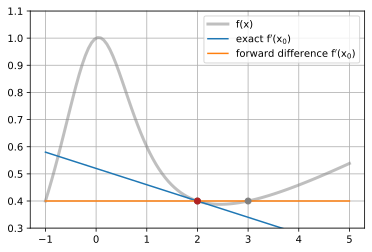

In [4]:
# fix value of h
h = 1

# compute exact tangent function at x0
fp = f0p0 + f0p1*(x-x0)

# function value at x0+h
f_ph = fnk(x0 + h)

# compute difference in function values
# f0p0 is the function (p0) value at x0 (f0)
df_fwd = f_ph - f0p0

# compute line at (x0, f0) with approximated slope
fp_fwd = f0p0 + df_fwd/h*(x-x0)

# plot function f(x)
plt.plot(x, f, lw=3, color='grey', alpha=alpha, label='$\sf f(x)$')

# plot tangent of f(x) at x0
plt.plot(x, fp, color='C0', label="exact $\sf f'(x_0)$")

# plot line at x0, f(x0) with slope computed by forward difference
plt.plot(x, fp_fwd, color='C1', label="forward difference $\sf f'(x_0)$")

# indicate function evaluation points
plt.scatter([x0, x0+h], [f0p0, f_ph], color='grey', zorder=3)
plt.scatter(x0, f0p0, color='firebrick', zorder=3)

plt.ylim(ylim)
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')

plt.savefig('./figs/derivative_forward.svg');
if show: plt.show()
plt.close()

:::{figure-md} fig-fwd-difference

<img src="./figs/derivative_forward.svg" width="90%">

First order forward difference formula.
:::

While the above formula used the value at $\mf x_0 + h$ and is thus called a forward differences formula, it is possible to use the function's value at $\mf x_0 - h$. This results in the backward differences formula

$$
\mf f'(x_0) = \frac{f(x_0) - f(x_0 - h)}{h} + \mathcal{O}(h)\quad .
$$

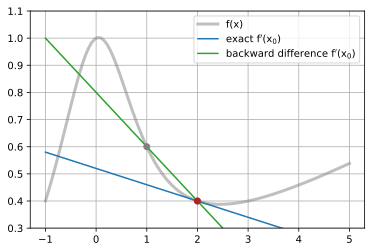

In [5]:
# function value at x0-h
f_nh = fnk(x0 - h)

# compite difference in function values
# f0p0 is the function (p0) value at x0 (f0)
df_bck = f0p0 - f_nh 

# compute line at (x0, f0) with approximated slope
fp_bck = f0p0 + df_bck/h*(x-x0)

# plot function f(x)
plt.plot(x, f, lw=3, color='grey', alpha=alpha, label='$\sf f(x)$')

# plot tangent of f(x) at x0
plt.plot(x, fp, color='C0', label="exact $\sf f'(x_0)$")

# plot line at x0, f(x0) with slope computed by back difference
plt.plot(x, fp_bck, color='C2', label="backward difference $\sf f'(x_0)$")

# indicate function evaluation points
plt.scatter([x0, x0-h], [f0p0, f_nh], color='grey', zorder=3)
plt.scatter(x0, f0p0, color='firebrick', zorder=3)

plt.ylim(ylim)
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')

plt.savefig('./figs/derivative_backward.svg');
if show: plt.show()
plt.close()

:::{figure-md} fig-bck-difference

<img src="./figs/derivative_backward.svg" width="90%">

First order backward difference formula.
:::

First order approximations are mostly not sufficient and higher order approximations are needed. Using more values of the function, i.e. the combination of multiple Taylor series, higher order formula may be derived, like for the second order central differences formula.

The following two Taylor series are used as starting point

$$
\begin{align} 
\mf f(x_0+h) &\mf= f(x_0) + f'(x_0)\cdot h + \frac{1}{2}f''(x_0)\cdot h^2 + \mathcal{O}(h^3) \\ 
\mf f(x_0-h) &\mf= f(x_0) - f'(x_0)\cdot h + \frac{1}{2}f''(x_0)\cdot h^2 + \mathcal{O}(h^3) 
\end{align}
$$

Subracting the first equation from the second

$$
\mf f(x_0+h) - f(x_0-h) = 2f'(x_0)\cdot h + \mathcal{O}(h^3)
$$

results in the central difference formula for the first derivative

$$
\mf f''(x_0) = \frac{f(x_0+h) - f(x_0-h)}{2h} + \mathcal{O}(h^2)\quad .
$$ (eq-cfd-central-derivative-snd)

The central differences formula is graphicaly represented in the following figure.

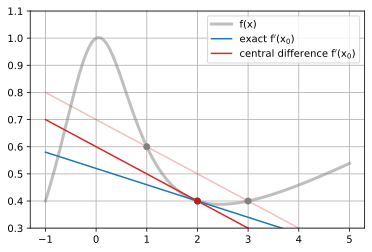

In [6]:
# compite difference in function values
# f0p0 is the function (p0) value at x0 (f0)
df_cnt = f_ph - f_nh

# compute line at (x0, f0) with approximated slope
fp_cnt = f0p0 + df_cnt/(2*h) * (x-x0)
# compute line at (x0+h, f(x0+h)) with approximated slope for illustration
fp_cnt_tmp = f_ph + df_cnt/(2*h) * (x-x0-h)

# plot function f(x)
plt.plot(x, f, lw=3, color='grey', alpha=alpha, label='$\sf f(x)$')

# plot tangent of f(x) at x0
plt.plot(x, fp, color='C0', label="exact $\sf f'(x_0)$")

# plot line at x0, f(x0) with slope computed by central difference
plt.plot(x, fp_cnt, color='C3', label="central difference $\sf f'(x_0)$")
plt.plot(x, fp_cnt_tmp, color='C3', alpha=0.3)

# indicate function evaluation points
plt.scatter([x0-h, x0, x0+h], [f_nh, f0p0, f_ph], color='grey', zorder=3)
plt.scatter(x0, f0p0, color='firebrick', zorder=3)

plt.ylim(ylim)
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')

plt.savefig('./figs/derivative_central.svg');
if show: plt.show()
plt.close()

:::{figure-md} fig-cnt-difference

<img src="./figs/derivative_central.svg" width="90%">

Second order central difference formula.
:::

All three presented methods are shown in a joint illustration in the next figure.

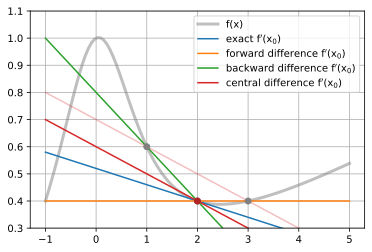

In [7]:
# plot function f(x)
plt.plot(x, f, lw=3, color='grey', alpha=alpha, label='$\sf f(x)$')

# plot tangent of f(x) at x0
plt.plot(x, fp, color='C0', label="exact $\sf f'(x_0)$")

# lines indicating the slope approximations
plt.plot(x, fp_fwd, color='C1', label="forward difference $\sf f'(x_0)$")
plt.plot(x, fp_bck, color='C2', label="backward difference $\sf f'(x_0)$")
plt.plot(x, fp_cnt, color='C3', label="central difference $\sf f'(x_0)$")
plt.plot(x, fp_cnt_tmp, color='C3', alpha=0.3)

# indicate function evaluation points
plt.scatter([x0-h, x0, x0+h], [f_nh, f0p0, f_ph], color='grey', zorder=3)
plt.scatter(x0, f0p0, color='firebrick', zorder=3)

plt.ylim(ylim)
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')

plt.savefig('./figs/derivative_all.svg');
if show: plt.show()
plt.close()

:::{figure-md} fig-all-difference

<img src="./figs/derivative_all.svg" width="90%">

Comparison of all above presented difference formula.
:::

It is also possible to derive directional (forward, backwards) formulas second order. The calculus leads to the follwoing formulas

$$
\begin{align}
\mf f''(x_0) &\mf= \frac{-3f(x_0) + 4f(x_0+h) - f(x_0+2h)}{2h} + \mathcal{O}(h^2) \\
\mf f''(x_0) &\mf= \frac{3f(x_0) - 4f(x_0-h) + f(x_0-2h)}{2h} + \mathcal{O}(h^2) \quad .
\end{align}
$$ (eq-cfd-directional-derivative-snd)

```{admonition} Task
Derive the discretisation formula for the second derivative

$$
\mf f''(x_0) = \frac{f(x_0-h) - 2f(x_0) + f(x_0+h)}{\Delta x^2} + \mathcal{O}(h^2)
$$ (eq-cfd-central-sndderivative-snd)
```

### Discretisation

In the above section, the derivative of a function was approximated at a single point, here $\mf x_0$. In order to compute the derivative of a function in a given interval $\mf x \in [x_b, x_e]$, a common approach is to discretise the interval. This means, that it is represented by a finite number of points. Given $\mf n_x$ as the number of representing points, the interval becomes the following finite set:

$$
\mf x \in [x_0, \dots, x_i, \dots, x_{n_x-1}]
$$

with

$$ 
\mf x_0 = x_b; \quad x_{n_x-1} = x_e
$$

If the representing points are equally spaced, then the distance $\mf \Delta x$ is

$$
\mf \Delta x = \frac{x_e - x_b}{n_x-1}\quad
$$

and the value of $\mf x_i$ is given by

$$
\mf x_i = x_b + i\cdot \Delta x \quad .
$$

In two and three dimensional cases, this discretisation can be represented as a mesh or grid, see {numref}`fig-field-model`. Thus $\mf \Delta x$ is often called grid spacing.

**Example of a discretisation:** Given $\mf n_x = 20$, the function in equation {eq}`eq-cfd-example-fnk` takes the following discrete representation.

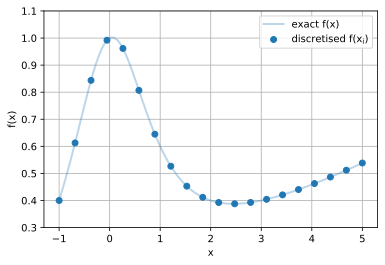

<Figure size 432x288 with 0 Axes>

In [20]:
nx = 20
dx = (xe - xb) / (nx - 1)
xi = np.linspace(xb, xe, nx)

fi = fnk(xi)

plt.plot(x, f, lw=2, color='C0', alpha=0.3, label='exact $\sf f(x)$')
plt.scatter( xi, fi, color='C0', zorder=5, label='discretised $\sf f(x_i)$')
# plt.vlines( xi, [0] * len(xi), fi, color='grey', alpha=0.3)

# line at y=0
# plt.axhline(0, color='black')

plt.legend()
plt.grid()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(ylim)
plt.savefig('./figs/discretisation.svg')
if show: plt.show()
plt.clf();

:::{figure-md} fig-cfd-discretisation

<img src="./figs/discretisation.svg" width="90%">

One dimensional discretisation.
:::

### Discrete Derivatives

Given the approximation formulars and a discretised function, it becomes possible to compute the function's derivative only with the usage of its values. The approximation formulas are evaluated with $\mf h = \Delta x$. 

For the function shown above and using the central differences second order {eq}`eq-cfd-central-derivative-snd`, plus the directional derivatives {eq}`eq-cfd-directional-derivative-snd` at the boundaries, the approximated derivative is shown in the following figure. 

In [8]:
# function to compute the first derivative with the 
# central differencing scheme
def central(x, y):
    yp = np.zeros_like(y)
    
    for i in range(1, len(x)-1):
        # central discretisation scheme
        yp[i] = (y[i+1] - y[i-1]) / (x[i+1] - x[i-1])
       
    # use of directional derivatives at the boundary
    yp[0]  = (-3*y[ 0] + 4*y[ 1] - y[ 2]) / (x[ 2] - x[ 0])
    yp[-1] = ( 3*y[-1] - 4*y[-2] + y[-3]) / (x[-1] - x[-3])
    
    return yp

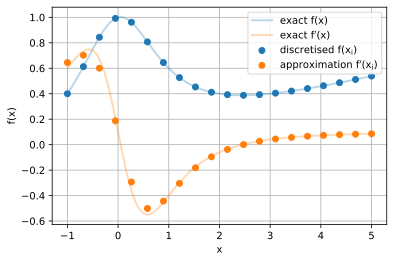

<Figure size 432x288 with 0 Axes>

In [21]:
# analytical solution of the derivative for comparison
fp = fnk(x, derivative=1)

# approximation of the derivative
fpi = central(xi, fi)

# plot of the function
plt.plot(x, f, lw=2, color='C0', alpha=0.3, label='exact $\sf f(x)$')
plt.scatter( xi, fi, color='C0', zorder=5, label='discretised $\sf f(x_i)$')

# plot of the derivative
plt.plot(x, fp, lw=2, color='C1', alpha=0.3, label="exact $\sf f'(x)$")
plt.scatter( xi, fpi, color='C1', zorder=5, label="approximation $\sf f'(x_i)$")

plt.legend()
plt.grid()
plt.xlabel('x')
plt.ylabel('f(x)')
# plt.ylim(ylim)
plt.savefig('./figs/discrete-derivative.svg')
if show: plt.show()
plt.clf();

:::{figure-md} fig-cfd-discrete-derivative

<img src="./figs/discrete-derivative.svg" width="90%">

Approximation of the first derivative.
:::

### Approximation Error

## Time Integration

## Finite Difference Method

### Scheme

### Stability

In [8]:
def central(x, y):
    yp = np.zeros_like(y)
    
    for i in range(1, len(x)-1):
        yp[i] = (y[i+1] - y[i-1]) / (x[i+1] - x[i-1])
        
    yp[0]  = (-3*y[ 0] + 4*y[ 1] - y[ 2]) / (x[ 2] - x[ 0])
    yp[-1] = ( 3*y[-1] - 4*y[-2] + y[-3]) / (x[-1] - x[-3])
    
    return yp

(-1.0, 1.2)

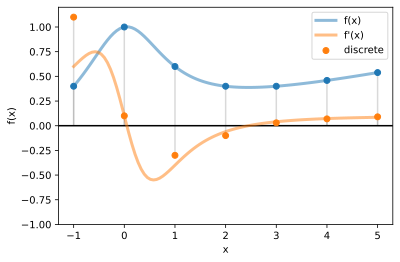

In [9]:
plt.axhline(y=0, color='black')
plt.plot(x, fnk(x), lw=3, color='C0', alpha=alpha, label='f(x)')
plt.plot(x, fnk(x, derivative=1), lw=3, color='C1', alpha=alpha, label="f'(x)")

dx = 1

px = np.arange(-1, 5 + 0.01*dx, dx)
pf = fnk(px)

plt.scatter( px, pf, color='C0', zorder=5)
plt.vlines( px, [0] * len(px), pf, color='grey', alpha=0.3)

pfp = central(px, pf)
plt.scatter( px, pfp, color='C1', zorder=5, label='discrete')
plt.vlines( px, [0] * len(px), pfp, color='grey', alpha=0.3)

plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-1, 1.2)


:::{figure-md} fig-fluid-time-setup

<img src="./figs/time_integration_1_setup.svg" width="80%" >

Time Integration.
:::

:::{figure-md} fig-fluid-time-explicit

<img src="./figs/time_integration_2_explicit.svg" width="80%" >

Time integration -- explicit Euler scheme.
:::

:::{figure-md} fig-fluid-time-implicit

<img src="./figs/time_integration_3_implicit.svg" width="80%" >

Time integration -- implicit Euler scheme.
:::

:::{figure-md} fig-fluid-time-twostep

<img src="./figs/time_integration_4_twostep.svg" width="80%" >

Time integration -- two step scheme.
:::

:::{figure-md} fig-fluid-time-predictorcorrector

<img src="./figs/time_integration_5_predictorcorrector.svg" width="80%" >

Time integration -- predictor-corrector scheme.
:::

## Finite Volume Method